# Exploration MERRA2 simulation from GMAO
------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation Friday 25 Novembre 2016
- checked : 0K January 6th 2017 with pyearth conda environnment


### purpose:

Analyse MERRA2 run for LSST air transparency simulation


http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release


In [3]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [5]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [6]:
from datetime import datetime, timedelta

In [7]:
import h5py

In [8]:
import libGMAOMERRA2Data as merra2  # My own library

In [9]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2018-04-25 11:24:54.598977
fits date format for the analysis :  2018-04-25T11:24:54


In [10]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 1) Access to the file through pyhdf
-------------------------

### 1.1 Setting the path to the data
--------------------------------

In [11]:
#os.environ["HDFEOS_ZOO_DIR"] = "/Users/dagoret-campagnesylvie/MacOSX/LSST/MyWork/GitHub/GMAOMERRA2data/inst1_2d_asm_Nx_M2I1NXASM"
os.environ["HDFEOS_ZOO_DIR"] = "/sps/lsst/data/AtmosphericCalibration/MERRA-2/May-Jun-2017/subset_M2I1NXASM_V5.12.4_20180424_201411"

In [17]:
#HDFEOS_ZOO_DIR="/Users/dagoret-campagnesylvie/MacOSX/LSST/MyWork/GitHub/GMAOMERRA2data/inst1_2d_asm_Nx_M2I1NXASM"
HDFEOS_ZOO_DIR="/sps/lsst/data/AtmosphericCalibration/MERRA-2/May-Jun-2017/subset_M2I1NXASM_V5.12.4_20180424_201411"

In [18]:
path=HDFEOS_ZOO_DIR

In [14]:
DATAFIELD_NAME =  'TO3'

In [15]:
DATAFIELD_UNIT =  'Db'

### 1.2 Getting the list of the files
------------------------------

In [19]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  
print nc4_files
full_nc4file=nc4_files
ix=0
for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4file[ix]=fname
    ix=ix+1    
print full_nc4file[0]

['MERRA2_400.inst1_2d_asm_Nx.20170502.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170522.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170511.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170616.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170603.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170530.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170615.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170506.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170613.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170503.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170526.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170517.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170525.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170619.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170607.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170514.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170605.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170508.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170507.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170524.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170623.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170614.nc4', 'MERRA2_400.inst1_2d_asm_Nx.20170627.nc4', 'MERRA2_40

### 1.3 Select a given file and open it

In [20]:
fileindex=0 # selecting the file to open : August 2016 

In [21]:
FILE_NAME=full_nc4file[fileindex] 

In [22]:
nc4f= h5py.File(FILE_NAME, mode='r')

In [23]:
nc4f.items()

[(u'U2M', <HDF5 dataset "U2M": shape (24, 361, 576), type "<f4">),
 (u'TROPT', <HDF5 dataset "TROPT": shape (24, 361, 576), type "<f4">),
 (u'TROPPB', <HDF5 dataset "TROPPB": shape (24, 361, 576), type "<f4">),
 (u'T2M', <HDF5 dataset "T2M": shape (24, 361, 576), type "<f4">),
 (u'TQL', <HDF5 dataset "TQL": shape (24, 361, 576), type "<f4">),
 (u'TOX', <HDF5 dataset "TOX": shape (24, 361, 576), type "<f4">),
 (u'lon', <HDF5 dataset "lon": shape (576,), type "<f8">),
 (u'PS', <HDF5 dataset "PS": shape (24, 361, 576), type "<f4">),
 (u'time', <HDF5 dataset "time": shape (24,), type "<i4">),
 (u'V50M', <HDF5 dataset "V50M": shape (24, 361, 576), type "<f4">),
 (u'DISPH', <HDF5 dataset "DISPH": shape (24, 361, 576), type "<f4">),
 (u'TO3', <HDF5 dataset "TO3": shape (24, 361, 576), type "<f4">),
 (u'TS', <HDF5 dataset "TS": shape (24, 361, 576), type "<f4">),
 (u'T10M', <HDF5 dataset "T10M": shape (24, 361, 576), type "<f4">),
 (u'TROPPT', <HDF5 dataset "TROPPT": shape (24, 361, 576), type

In [19]:
#nc4f??

## Build Top directory and figure filename

In [24]:
base_filename=os.path.basename(FILE_NAME).split('.nc4')[0]

In [25]:
print base_filename

MERRA2_400.inst1_2d_asm_Nx.20170502


In [26]:
p = re.compile('[.]')
root_filename=p.sub('_',base_filename)    
rootimg_dir=os.path.join('images',root_filename)

In [27]:
rootimg_dir

'images/MERRA2_400_inst1_2d_asm_Nx_20170502'

In [28]:
ensure_dir(rootimg_dir)

In [29]:
pegfile = "{0}_{1}.jpg".format(root_filename, DATAFIELD_NAME)

In [30]:
figfilename=root_filename+'_'+ DATAFIELD_NAME+".pdf"
print figfilename

MERRA2_400_inst1_2d_asm_Nx_20170502_TO3.pdf


In [31]:
fullfigfilename=os.path.join(rootimg_dir,figfilename)

In [33]:
fullfigfilename

'images/MERRA2_400_inst1_2d_asm_Nx_20170502/MERRA2_400_inst1_2d_asm_Nx_20170502_TO3.pdf'

### 1.4 retrieve the 3D Data

In [34]:
name = '/TO3'
data = nc4f[name][0,:,:]
units = nc4f[name].attrs['units']
long_name = nc4f[name].attrs['long_name']
_FillValue = nc4f[name].attrs['_FillValue']
data[data == _FillValue] = np.nan
data = np.ma.masked_where(np.isnan(data), data)    

In [35]:
time_long_name = nc4f['/time'].attrs['long_name']  

In [36]:
# Get the geolocation data.
latitude = nc4f['/lat'][:]
longitude = nc4f['/lon'][:]

# Get the time data.
time = nc4f['/time'][:]
time_units = nc4f['/time'].attrs['units']

In [37]:
time

array([   0,   60,  120,  180,  240,  300,  360,  420,  480,  540,  600,
        660,  720,  780,  840,  900,  960, 1020, 1080, 1140, 1200, 1260,
       1320, 1380], dtype=int32)

In [38]:
print time_units

minutes since 2017-05-02 00:00:00


In [39]:
start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",time_units)

In [40]:
print start_time

['2017-05-02']


In [41]:
time_rng = pd.date_range(start_time[0], periods=time.shape[0], freq='H')

In [42]:
time_rng

DatetimeIndex(['2017-05-02 00:00:00', '2017-05-02 01:00:00',
               '2017-05-02 02:00:00', '2017-05-02 03:00:00',
               '2017-05-02 04:00:00', '2017-05-02 05:00:00',
               '2017-05-02 06:00:00', '2017-05-02 07:00:00',
               '2017-05-02 08:00:00', '2017-05-02 09:00:00',
               '2017-05-02 10:00:00', '2017-05-02 11:00:00',
               '2017-05-02 12:00:00', '2017-05-02 13:00:00',
               '2017-05-02 14:00:00', '2017-05-02 15:00:00',
               '2017-05-02 16:00:00', '2017-05-02 17:00:00',
               '2017-05-02 18:00:00', '2017-05-02 19:00:00',
               '2017-05-02 20:00:00', '2017-05-02 21:00:00',
               '2017-05-02 22:00:00', '2017-05-02 23:00:00'],
              dtype='datetime64[ns]', freq='H')

In [43]:
ts = pd.Series(np.random.randn(len(time_rng)), index=time_rng)

/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


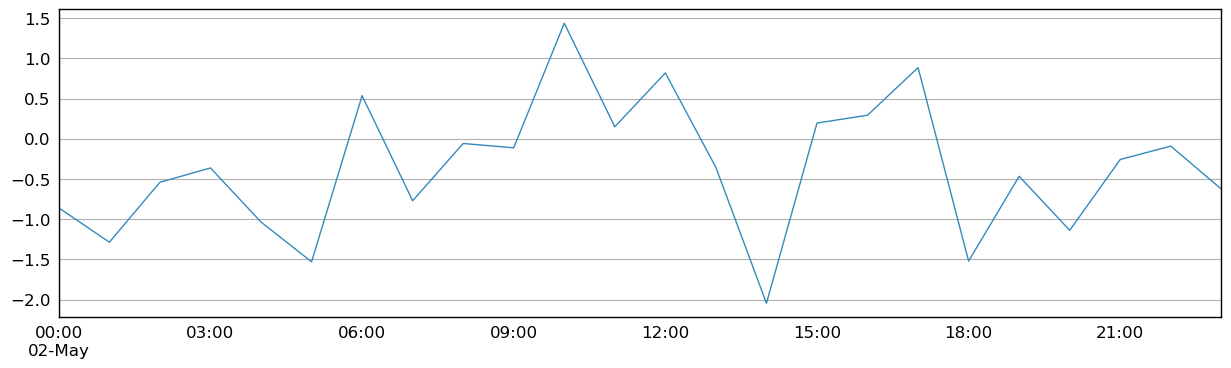

In [44]:
plt.figure(figsize=(15,4))
ts.plot()

In [45]:
pd.to_datetime(ts, format='%Y-%m-%d %H:%M:%S.%f')

2017-05-02 00:00:00   1970-01-01 00:00:00.000000000
2017-05-02 01:00:00   1969-12-31 23:59:59.999999999
2017-05-02 02:00:00   1970-01-01 00:00:00.000000000
2017-05-02 03:00:00   1970-01-01 00:00:00.000000000
2017-05-02 04:00:00   1969-12-31 23:59:59.999999999
2017-05-02 05:00:00   1969-12-31 23:59:59.999999999
2017-05-02 06:00:00   1970-01-01 00:00:00.000000000
2017-05-02 07:00:00   1970-01-01 00:00:00.000000000
2017-05-02 08:00:00   1970-01-01 00:00:00.000000000
2017-05-02 09:00:00   1970-01-01 00:00:00.000000000
2017-05-02 10:00:00   1970-01-01 00:00:00.000000001
2017-05-02 11:00:00   1970-01-01 00:00:00.000000000
2017-05-02 12:00:00   1970-01-01 00:00:00.000000000
2017-05-02 13:00:00   1970-01-01 00:00:00.000000000
2017-05-02 14:00:00   1969-12-31 23:59:59.999999998
2017-05-02 15:00:00   1970-01-01 00:00:00.000000000
2017-05-02 16:00:00   1970-01-01 00:00:00.000000000
2017-05-02 17:00:00   1970-01-01 00:00:00.000000000
2017-05-02 18:00:00   1969-12-31 23:59:59.999999999
2017-05-02 1

In [46]:
pp = PdfPages(fullfigfilename)

### 1.4 Data analysis
----------------------

#### 1.4.1 list of quantities to analyse

### Location of the CTIO site
------------------------------------
- Longitude = -70.815 deg
- Latitude  = -30.165277777777778 deg
- Quantity  = 2214.9999999993697 m

In [47]:
#CTIO site
Longitude_ctio = -70.815  # deg
Latitude_ctio = -30.165277777777778 #deg
Altitude_ctio = 2214.9999999993697 #m

## 2 Analysis of Ozone
--------------------------------------

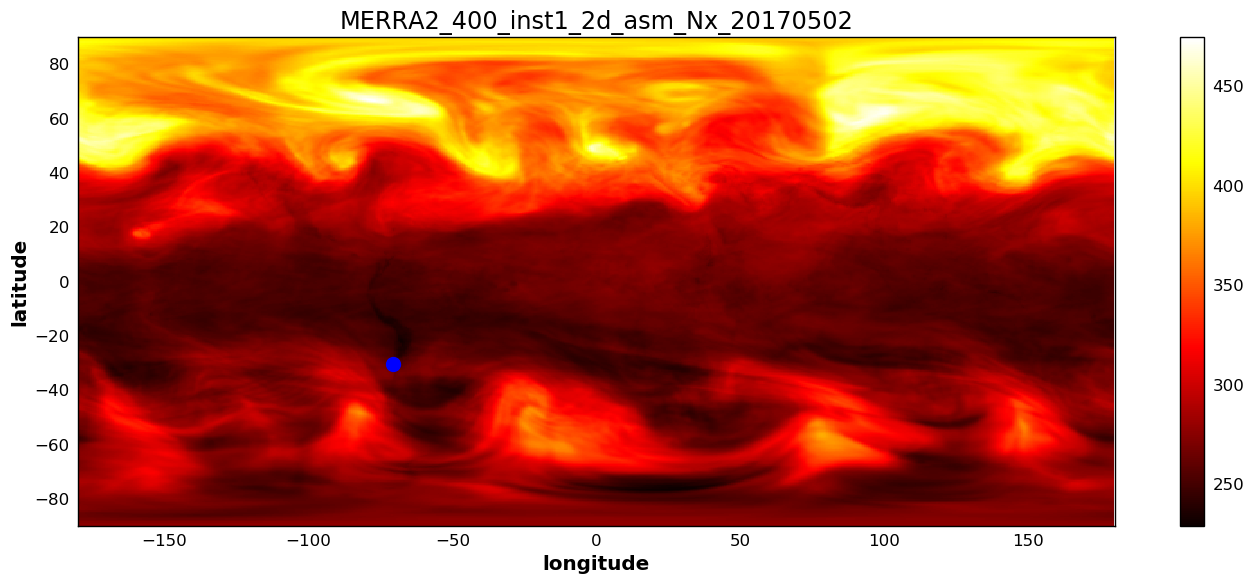

In [48]:
fig=plt.figure(figsize=(14,6))
#X,Y=np.meshgrid(all_longitude,all_latitude)
im = plt.pcolormesh(longitude,latitude,data, cmap='hot')
plt.colorbar(im, orientation='vertical')
plt.axis([-180., 180., -90, 90 ])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.plot([Longitude_ctio],[Latitude_ctio],'bo',markersize=10)
title=root_filename
plt.title(title)
plt.tight_layout()
plt.savefig(pp, format='pdf')
plt.show()

##### Using basemap

In [50]:
X,Y=np.meshgrid(longitude,latitude)

/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b

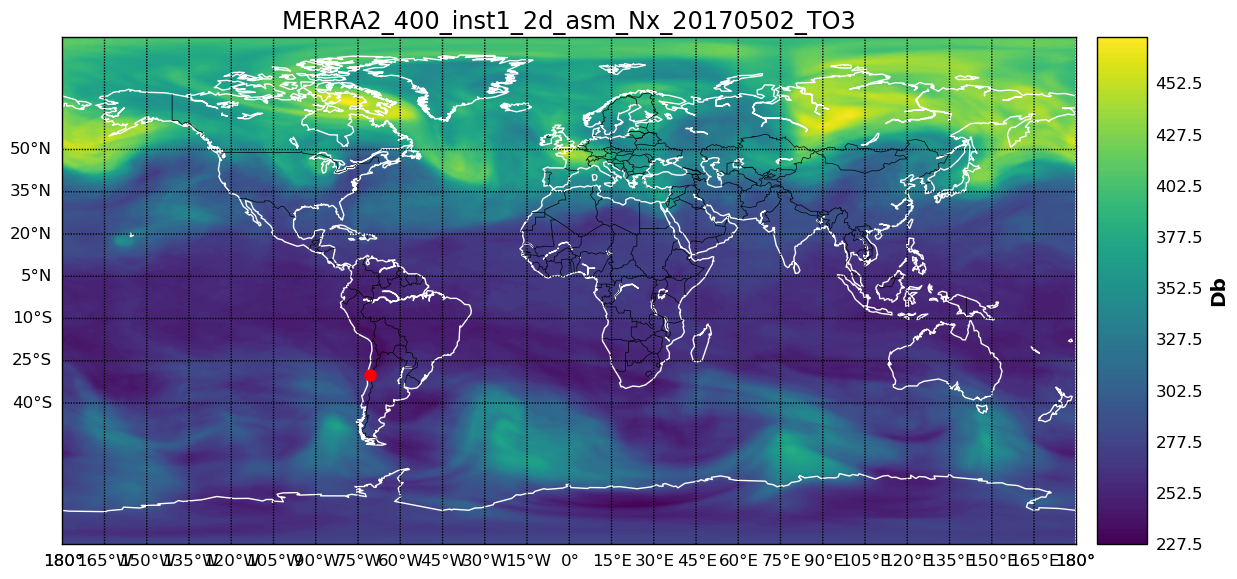

In [51]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize=(14,14))
map = Basemap()
map.drawcoastlines(color="white")
map.drawcountries(color="black")
img=map.contourf(X,Y, data,100)
cbar=map.colorbar(img,"right", size="5%", pad="2%")
cbar.set_label(DATAFIELD_UNIT)
map.drawparallels(np.arange(-40,61.,15.),labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,180.,15.),labels=[True,False,False,True])
xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
map.plot(xpt_ctio,ypt_ctio,marker='o',color='r',markersize=8)  # plot a red dot there
title=root_filename+'_'+ DATAFIELD_NAME
plt.title(title)
#plt.tight_layout() 
plt.savefig(pp, format='pdf')
plt.show()

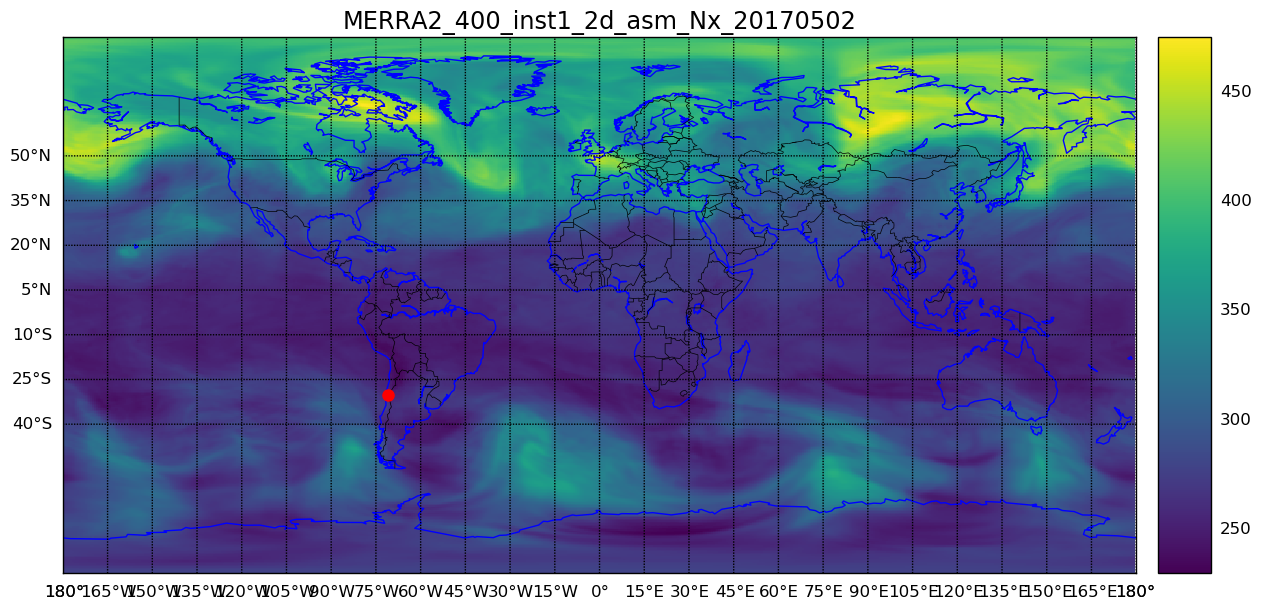

In [52]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
map = Basemap()
map.drawcoastlines(color="blue")
map.drawcountries(color="black")
#img=map.contourf(X, Y, aod_clean,100)
img = plt.pcolormesh(longitude,latitude,data)
map.colorbar(img,"right", size="5%", pad="2%")
map.drawparallels(np.arange(-40,61.,15.),labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,180.,15.),labels=[True,False,False,True])
xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
map.plot(xpt_ctio,ypt_ctio,'ro',markersize=8)  # plot a red dot there
#plt.text(xpt_lsst-100000,ypt_lsst-200000,'LSST (%5.1fW,%3.1fN)' % (Longitude_lsst,Latitude_lsst),color='red', fontsize=15)
title=root_filename
plt.title(title)
plt.tight_layout() 
plt.savefig(pp, format='pdf')
plt.show()

#### South America
-----------------

In [53]:
#LSST site
Longitude_lsst = -70.7366833333333 # deg
Latitude_lsst = -30.240741666666672 #deg
Altitude_lsst = 2749.999999999238 #m

#CTIO Site
Longitude_ctio = -70.815 # deg
Latitude_ctio = -30.165277777777778 #deg
Altitude_ctio = 2214.9999999993697 #m

# Cerro Paranal
Longitude_paranal = -70.40300000000002 #deg
Latitude_paranal  = -24.625199999999996 #deg
Altitude_paranal = 2635.0000000009704 #m

# Observatoire de Haute Provence
Longitude_ohp=5.71222222222
Latitude_ohp=43.9316666667
Altitude_ohp=650.

#### define south america

- longitude -100° to -30°
- latitude -55° to 15°

/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


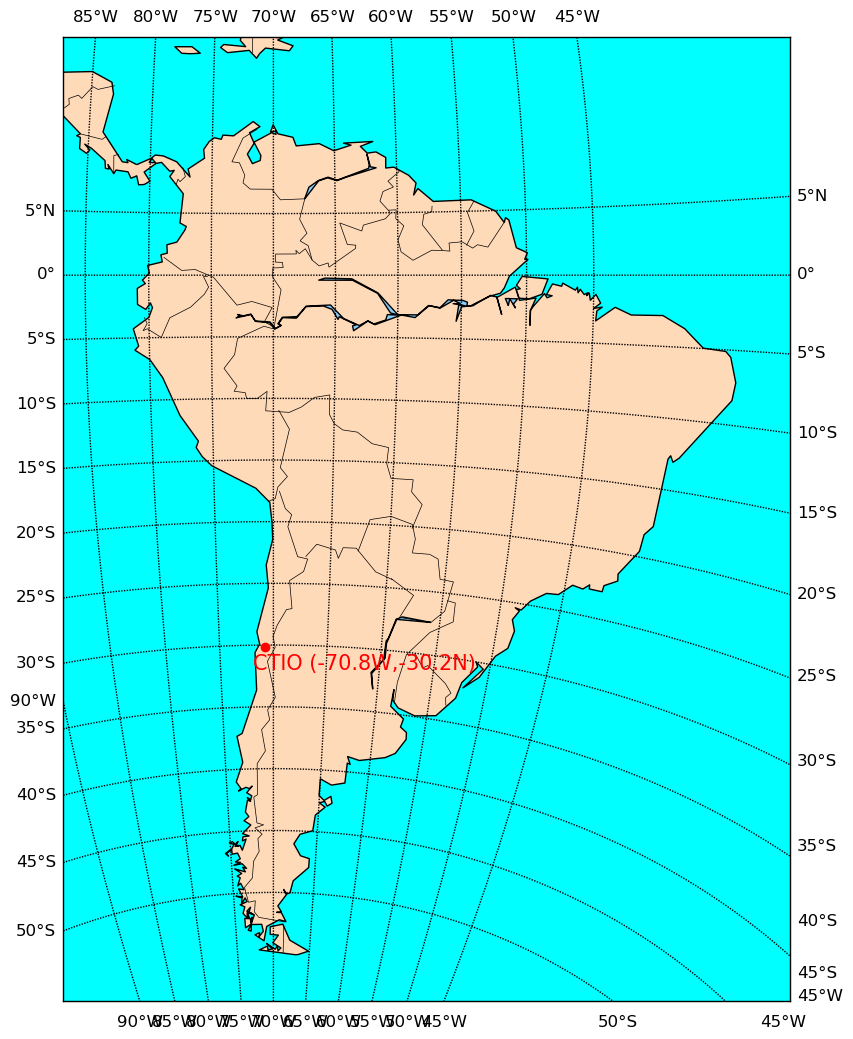

In [54]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
#map = Basemap(llcrnrlon=-100,llcrnrlat=-60,urcrnrlon=-25.,urcrnrlat=15.,resolution='i', projection='tmerc', lat_0 = -30, lon_0 = -70)

map = Basemap(llcrnrlon=-100,llcrnrlat=-55,urcrnrlon=-30.,urcrnrlat=15., projection='tmerc', lat_0 = -30, lon_0 = -70)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='peachpuff',lake_color='lightskyblue')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(-50,10,5.),labels=[True,True,True,True])
map.drawmeridians(np.arange(-90.,-40.,5.),labels=[True,True,True,True])

xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
# convert back to lat/lon
#lonpt, latpt = map(xpt_lsst,ypt_lsst,inverse=True)
map.plot(xpt_ctio,ypt_ctio,'ro')  # plot a red dot there
# put some text next to the dot, offset a little bit
# (the offset is in map projection coordinates)
plt.text(xpt_ctio-100000,ypt_ctio-200000,'CTIO (%5.1fW,%3.1fN)' % (Longitude_ctio,Latitude_ctio),color='red', fontsize=15)
plt.tight_layout()
plt.savefig(pp, format='pdf')
plt.show()


### Region and Data selection for South America

In [55]:
LongMin=-100
LongMax=-30
LatMin=-55
LatMax=15

In [56]:
X.shape

(361, 576)

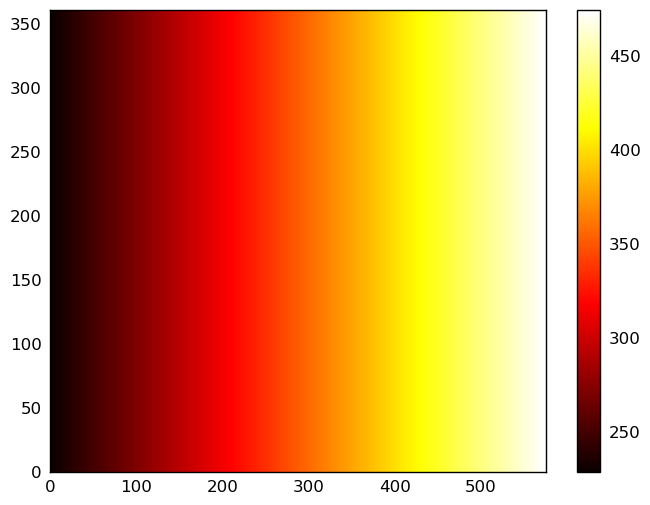

In [57]:
plt.pcolormesh(X, cmap='hot')
plt.colorbar(im, orientation='vertical')

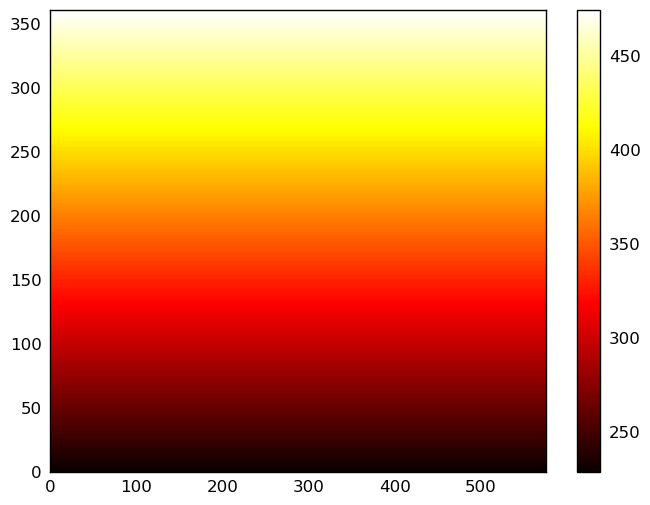

In [58]:
plt.pcolormesh(Y, cmap='hot')
plt.colorbar(im, orientation='vertical')

In [59]:
longitude=X
latitude=Y

In [60]:
flags_long=np.logical_and(X>=LongMin, X<=LongMax)   # flags in X where are the selected longitudes
flags_lat=np.logical_and(Y>=LatMin, Y<=LatMax)      # flags in Y where are the selected longitudes
flags_longlat=np.logical_and(flags_long,flags_lat)  # flags where the region is selected in the long-lat matrix

(selected_lat_indexes,selected_long_indexes)=np.where(flags_longlat==True) # list of indexes


selected_long=longitude[:,selected_long_indexes] # all selected longitudes
selected_lat=latitude[selected_lat_indexes,:]    # all selected latitudes

min_long_index=np.min(selected_long_indexes)
max_long_index=np.max(selected_long_indexes)

min_lat_index=np.min(selected_lat_indexes)
max_lat_index=np.max(selected_lat_indexes)

extracted_data=data[min_lat_index:max_lat_index,min_long_index:max_long_index] # extract the data

Xsel=X[min_lat_index:max_lat_index,min_long_index:max_long_index] # extract the Long
Ysel=Y[min_lat_index:max_lat_index,min_long_index:max_long_index] # extract the lat

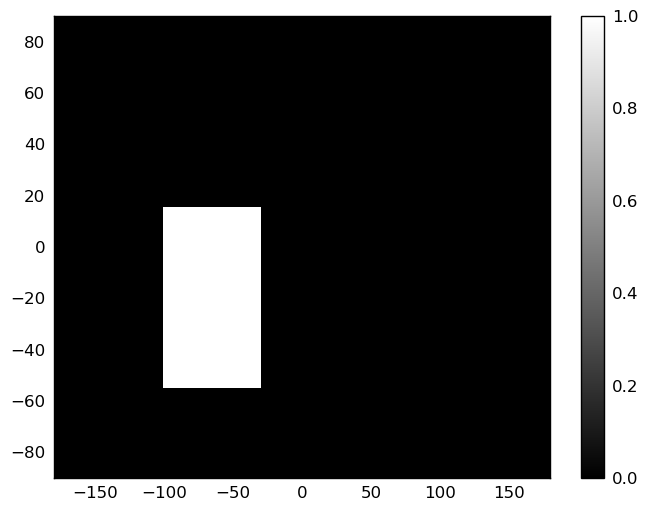

In [61]:
im=plt.pcolormesh(X,Y,flags_longlat, cmap='gray')
plt.colorbar(im, orientation='vertical')

In [62]:
(index_lat,index_long)=np.where(flags_longlat==True)

In [63]:
print selected_long

[[-100.     -99.375  -98.75  ...,  -31.25   -30.625  -30.   ]
 [-100.     -99.375  -98.75  ...,  -31.25   -30.625  -30.   ]
 [-100.     -99.375  -98.75  ...,  -31.25   -30.625  -30.   ]
 ..., 
 [-100.     -99.375  -98.75  ...,  -31.25   -30.625  -30.   ]
 [-100.     -99.375  -98.75  ...,  -31.25   -30.625  -30.   ]
 [-100.     -99.375  -98.75  ...,  -31.25   -30.625  -30.   ]]


In [64]:
print np.where(flags_longlat==True)
selected_long_indexes=np.where(flags_longlat==True)[0]
selected_lat_indexes=np.where(flags_longlat==True)[1]

(array([ 70,  70,  70, ..., 210, 210, 210]), array([128, 129, 130, ..., 238, 239, 240]))


In [65]:
selected_long_indexes

array([ 70,  70,  70, ..., 210, 210, 210])

In [66]:
selected_lat_indexes

array([128, 129, 130, ..., 238, 239, 240])

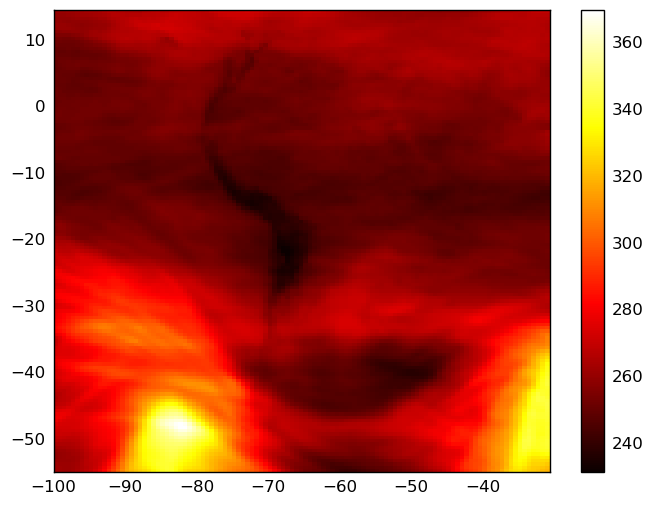

In [67]:
im=plt.pcolormesh(Xsel,Ysel,extracted_data, cmap='hot')
plt.colorbar(im, orientation='vertical')

In [68]:
# check what has been done
print('selected_long_indexes=',selected_long_indexes)
print('selected_lat_indexes=',selected_lat_indexes)
print('selected_long=',selected_long)
print('selected_lat=',selected_lat)
print("flags_longlat.shape=",flags_longlat.shape)
print("flags_long.shape=",flags_long.shape)
print("flags_lat.shape=",flags_lat.shape)
print("total number of ll bins",flags_longlat.shape[0]*flags_longlat.shape[1])
print("min_long_index=",min_long_index)
print("max_long_index=",max_long_index)
print("min_lat_index=",min_lat_index)
print("max_lat_index=",max_lat_index)
print("extracted_data.shape=",extracted_data.shape)
print("extracted_data.size=",extracted_data.shape[0]*extracted_data.shape[1])
#print("extracted_aod=",extracted_aod)

('selected_long_indexes=', array([ 70,  70,  70, ..., 210, 210, 210]))
('selected_lat_indexes=', array([128, 129, 130, ..., 238, 239, 240]))
('selected_long=', array([[-100.   ,  -99.375,  -98.75 , ...,  -31.25 ,  -30.625,  -30.   ],
       [-100.   ,  -99.375,  -98.75 , ...,  -31.25 ,  -30.625,  -30.   ],
       [-100.   ,  -99.375,  -98.75 , ...,  -31.25 ,  -30.625,  -30.   ],
       ..., 
       [-100.   ,  -99.375,  -98.75 , ...,  -31.25 ,  -30.625,  -30.   ],
       [-100.   ,  -99.375,  -98.75 , ...,  -31.25 ,  -30.625,  -30.   ],
       [-100.   ,  -99.375,  -98.75 , ...,  -31.25 ,  -30.625,  -30.   ]]))
('selected_lat=', array([[-55., -55., -55., ..., -55., -55., -55.],
       [-55., -55., -55., ..., -55., -55., -55.],
       [-55., -55., -55., ..., -55., -55., -55.],
       ..., 
       [ 15.,  15.,  15., ...,  15.,  15.,  15.],
       [ 15.,  15.,  15., ...,  15.,  15.,  15.],
       [ 15.,  15.,  15., ...,  15.,  15.,  15.]]))
('flags_longlat.shape=', (361, 576))
('flags_lon

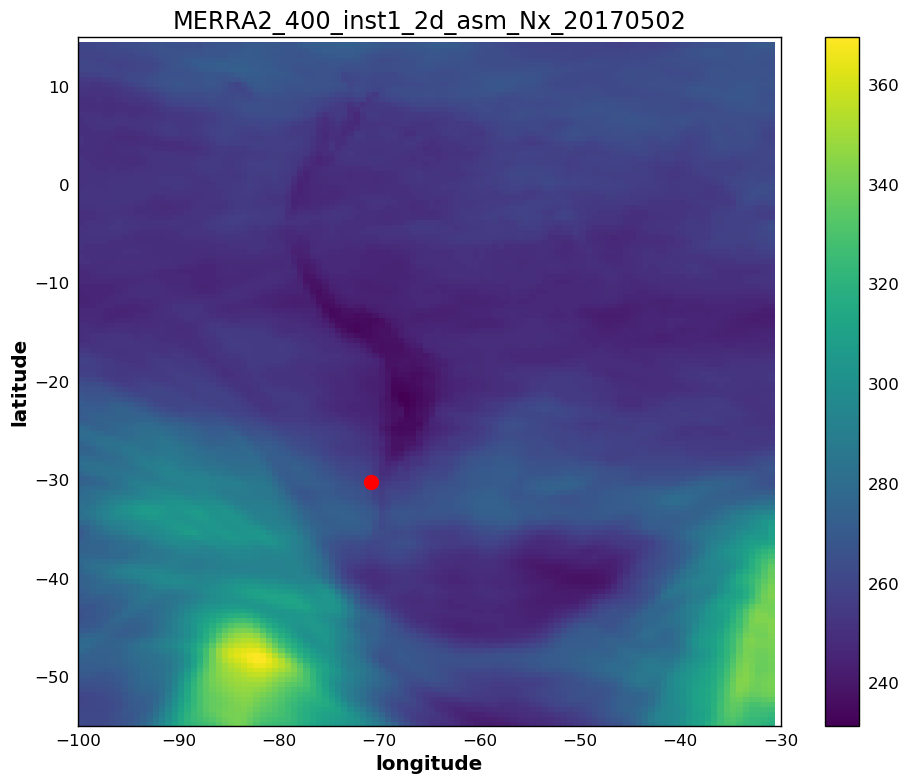

In [69]:
plt.figure(figsize=(10,8))
#newdata=np.where(flags_longlat,data  , 0 )  # clean the aod from creazy data
#image = plt.pcolormesh(X,Y,newdata, cmap='hot')
image = plt.pcolormesh(Xsel,Ysel,extracted_data)
plt.xlim(LongMin,LongMax)
plt.ylim(LatMin,LatMax)
plt.plot([Longitude_ctio],[Latitude_ctio],'ro',markersize=10)
plt.xlabel('longitude')
plt.ylabel('latitude')
title=root_filename
plt.title(title)
plt.tight_layout()
plt.colorbar(image, orientation='vertical')
plt.savefig(pp, format='pdf')
plt.show()

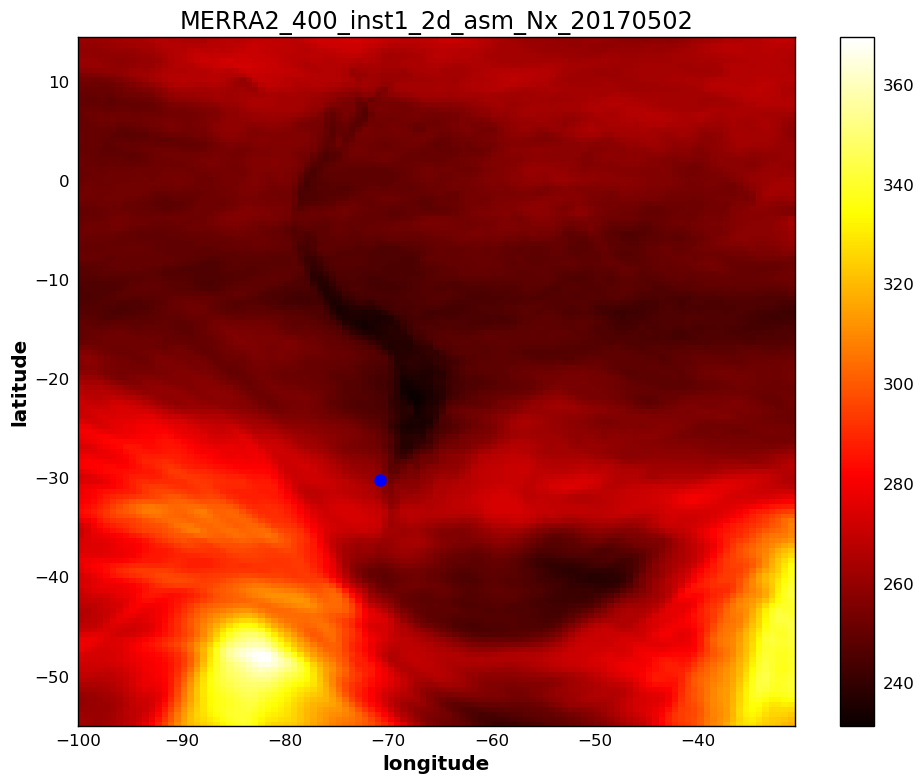

In [70]:
plt.figure(figsize=(10,8))
#Xsel,Ysel=np.meshgrid(selected_long,selected_lat)
im = plt.pcolormesh(Xsel,Ysel,extracted_data, cmap='hot')
plt.colorbar(im, orientation='vertical')
plt.axis([Xsel.min(), Xsel.max(), Ysel.min(), Ysel.max()])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.plot([Longitude_ctio],[Latitude_ctio],marker='o',color='b',markersize=8)
#title="Aerosol Optical Depth AOD above europe"
title=root_filename
plt.title(title)
plt.tight_layout()
plt.savefig(pp, format='pdf')
plt.show()

/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


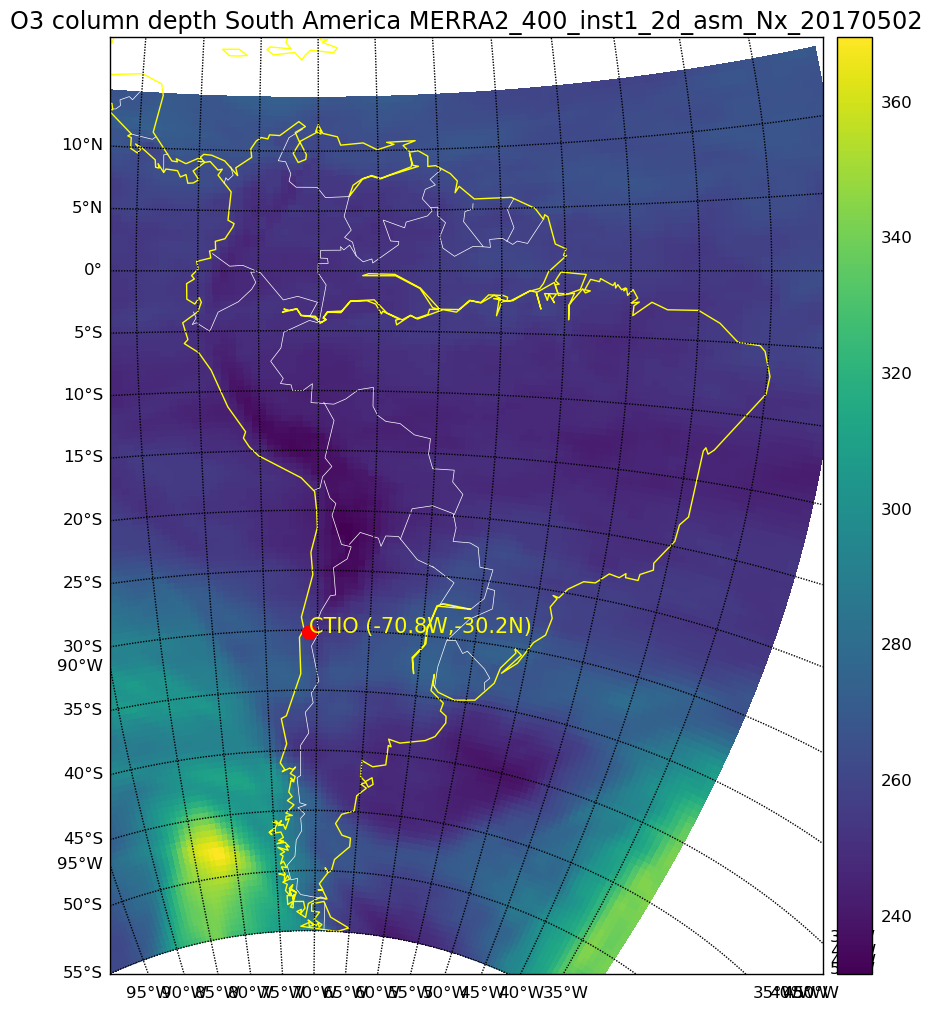

In [71]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
map = Basemap(llcrnrlon=LongMin,llcrnrlat=LatMin,urcrnrlon=LongMax,urcrnrlat=LatMax, projection='tmerc', lat_0 = Latitude_ctio, lon_0 = Longitude_ctio)
#map.drawmapboundary(fill_color='aqua') # No fill color
#map.fillcontinents(color='peachpuff',lake_color='lightskyblue') # No fill color
xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
# convert back to lat/lon
#lonpt, latpt = map(xpt_lsst,ypt_lsst,inverse=True)
map.plot(xpt_ctio,ypt_ctio,'ro')  # plot a red dot there

img=map.pcolormesh(Xsel,Ysel,extracted_data,shading='flat',latlon=True)
#img=map.contourf(Xsel, Ysel, extracted_aod,100)
map.colorbar(img,"right", size="5%", pad="2%")
map.drawparallels(np.arange(LatMin,LatMax,5.),labels=[True,False,False,False])
map.drawmeridians(np.arange(LongMin,LongMax,5.),labels=[True,True,False,True])
map.drawcoastlines(color='yellow')
map.drawcountries(color='white')
xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
map.plot(xpt_ctio,ypt_ctio,'ro',markersize=10)  # plot a red dot there
plt.text(xpt_ctio-1000,ypt_ctio-1000,'CTIO (%5.1fW,%3.1fN)' % (Longitude_ctio,Latitude_ctio),color='yellow', fontsize=15)
title="O3 column depth South America " + root_filename
plt.title(title)
plt.tight_layout()
plt.savefig(pp, format='pdf')
plt.show()

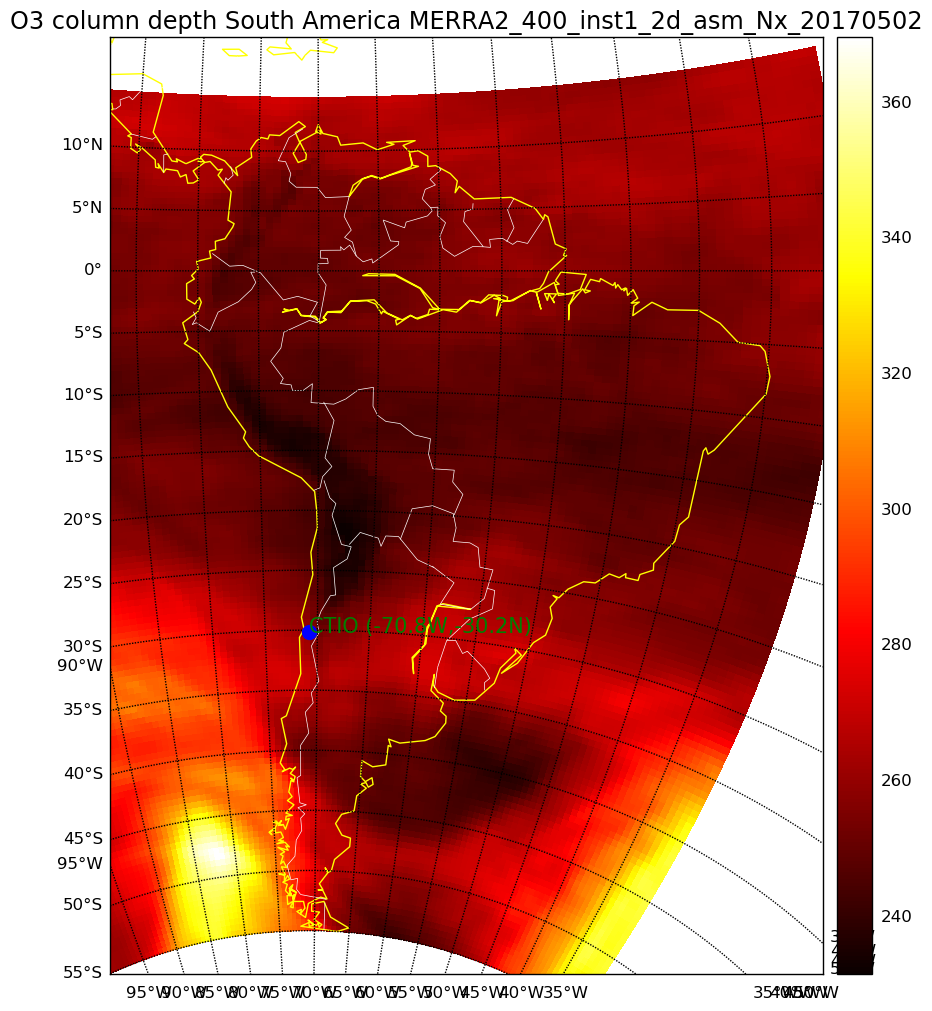

In [72]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
map = Basemap(llcrnrlon=LongMin,llcrnrlat=LatMin,urcrnrlon=LongMax,urcrnrlat=LatMax, projection='tmerc', lat_0 = Latitude_ctio, lon_0 = Longitude_ctio)
xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
# convert back to lat/lon
#lonpt, latpt = map(xpt_lsst,ypt_lsst,inverse=True)
map.plot(xpt_ctio,ypt_ctio,'ro')  # plot a red dot there
img=map.pcolormesh(Xsel,Ysel,extracted_data,shading='flat',cmap="hot",latlon=True)
#img=map.contourf(Xsel, Ysel, extracted_aod,20)
map.colorbar(img,"right", size="5%", pad="2%")
map.drawparallels(np.arange(LatMin,LatMax,5.),labels=[True,False,False,False])
map.drawmeridians(np.arange(LongMin,LongMax,5.),labels=[True,True,False,True])
map.drawcoastlines(color='yellow')
map.drawcountries(color='white')
xpt_ctio,ypt_ctio = map(Longitude_ctio,Latitude_ctio)
map.plot(xpt_ctio,ypt_ctio,'bo',markersize=10)  # plot a red dot there
plt.text(xpt_ctio-1000,ypt_ctio-1000,'CTIO (%5.1fW,%3.1fN)' % (Longitude_ctio,Latitude_ctio),color='green', fontsize=15)
title="O3 column depth South America "+root_filename
plt.title(title)
plt.tight_layout()
plt.savefig(pp, format='pdf')
plt.show()

#### Find O3 data for CTIO site
------------------------------

In [73]:
(NbBinLat,NbBinLong)=longitude.shape

In [74]:
DeltaBinLat=180./float(NbBinLat)
DeltaBinLong=360./float(NbBinLong)

In [75]:
print "dlat = ",DeltaBinLat
print "dlong = ",DeltaBinLong

dlat =  0.498614958449
dlong =  0.625


In [76]:
ctio_flags_long=np.logical_and(X>=Longitude_ctio-DeltaBinLong/2., X<=Longitude_ctio+DeltaBinLong/2.)   # flags in X where are the selected longitudes
ctio_flags_lat=np.logical_and(Y>=Latitude_ctio-DeltaBinLat/2., Y<=Latitude_ctio+DeltaBinLat/2.)      # flags in Y where are the selected longitudes
ctio_flags_longlat=np.logical_and(ctio_flags_long,ctio_flags_lat)  # flags where the region is selected in the long-lat matrix

(ctio_selected_lat_indexes,ctio_selected_long_indexes)=np.where(ctio_flags_longlat==True) # list of indexes


ctio_selected_long=longitude[:,ctio_selected_long_indexes] # all selected longitudes
ctio_selected_lat=latitude[ctio_selected_lat_indexes,:] 

ctio_min_long_index=np.min(ctio_selected_long_indexes)
ctio_max_long_index=np.max(ctio_selected_long_indexes)

ctio_min_lat_index=np.min(ctio_selected_lat_indexes)
ctio_max_lat_index=np.max(ctio_selected_lat_indexes)

ctio_extracted_data=data[ctio_min_lat_index:ctio_max_lat_index+1,ctio_min_long_index:ctio_max_long_index+1] # extract the data

In [77]:
print('ctio_selected_long_indexes=',ctio_selected_long_indexes)
print('ctio_selected_lat_indexes=',ctio_selected_lat_indexes)
print('ctio_min_lat_index=',ctio_min_lat_index)
print('ctio_max_lat_index=',ctio_max_lat_index)
print('ctio_min_long_index=',ctio_min_long_index)
print('ctio_max_long_index=',ctio_max_long_index)
#print('ctio_selected_lat=',ctio_selected_lat)

print('A) ctio_data = ',ctio_extracted_data[0][0],' Db Unit')
print('B) ctio_data = ',data[ctio_min_lat_index,ctio_min_long_index],' Db Unit')

('ctio_selected_long_indexes=', array([175]))
('ctio_selected_lat_indexes=', array([120]))
('ctio_min_lat_index=', 120)
('ctio_max_lat_index=', 120)
('ctio_min_long_index=', 175)
('ctio_max_long_index=', 175)
('A) ctio_data = ', 256.38162, ' Db Unit')
('B) ctio_data = ', 256.38162, ' Db Unit')


In [78]:
data.shape

(361, 576)

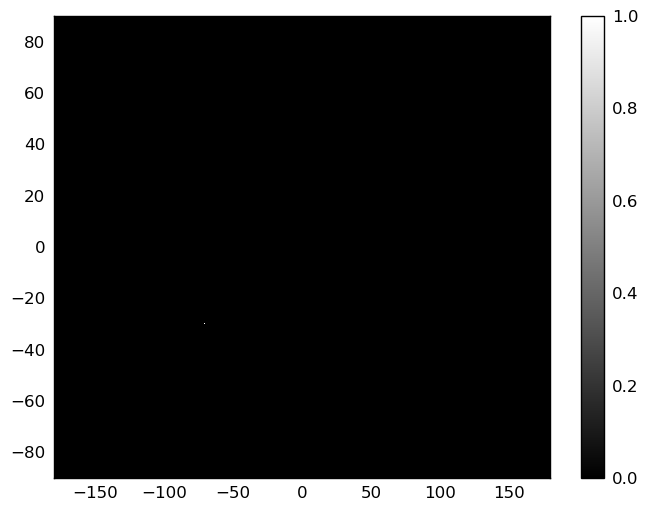

In [79]:
im=plt.pcolormesh(X,Y,ctio_flags_longlat, cmap='gray')
plt.colorbar(im, orientation='vertical')

### Test library libGMAOMERRA2Data

In [80]:
fullfigfilename

'images/MERRA2_400_inst1_2d_asm_Nx_20170502/MERRA2_400_inst1_2d_asm_Nx_20170502_TO3.pdf'

In [81]:
(data3D,unit,longname)=merra2.GetGeoRefData(FILE_NAME,DATAFIELD_NAME)
m_data= data3D[:,:,:] ## Ozone has no additional dimensions
(m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(FILE_NAME,'lat')
m_latitude = m_lat[:]
(m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(FILE_NAME,'lon')
m_longitude = m_lon[:]
(m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(FILE_NAME,'time')
m_time=m_tim[:]

In [82]:
m_X,m_Y=np.meshgrid(m_longitude,m_latitude)

In [83]:
loc=merra2.observatory_location('ctio')

In [84]:
(sel_long,sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1],DLong=DeltaBinLong,DLat=DeltaBinLong)

In [85]:
m_data[:,sel_lat,sel_long]

masked_array(data = [ 256.38162231  256.60272217  256.98828125  257.58050537  259.00869751
  259.89089966  260.69839478  261.45626831  262.18121338  262.99359131
  263.21160889  263.32089233  263.25878906  264.22351074  265.71942139
  268.6763916   271.20166016  272.88134766  273.01965332  272.99743652
  274.77914429  276.49325562  273.8921814   274.08825684],
             mask = False,
       fill_value = 1e+20)

### Find size of MERRA2 box at CTIO location

In [86]:
(NbBinLat,NbBinLong)=longitude.shape

In [87]:
DeltaBinLat=180./float(NbBinLat)
DeltaBinLong=360./float(NbBinLong)

In [88]:
DeltaBinLat

0.4986149584487535

In [89]:
#distance along longitude
x1,y1 = map(Longitude_ctio-DeltaBinLong/2.,Latitude_ctio)
x2,y2 = map(Longitude_ctio+DeltaBinLong/2.,Latitude_ctio)
d_long=np.sqrt((x2-x1)**2+(y2-y1)**2)/1000

In [90]:
print x1,x2,y1,y2
print d_long,' km'

1806810.09523 1867013.99051 3156203.07529 3156203.07529
60.2038952883  km


In [91]:
#distance along latitude
x1,y1 = map(Longitude_ctio,Latitude_ctio-DeltaBinLat/2.)
x2,y2 = map(Longitude_ctio,Latitude_ctio+DeltaBinLat/2.)
d_lat=np.sqrt((x2-x1)**2+(y2-y1)**2)/1000

In [92]:
print x1,x2,y1,y2
print d_lat,' km'

1836912.04287 1836912.04287 3128606.76062 3183880.8396
55.2740789741  km


## Close the pdf file
-------------------------

In [93]:
pp.close()

In [94]:
X.shape

(361, 576)

In [95]:
180./361

0.4986149584487535

In [96]:
360./576

0.625